# PyironFlow demo

Uncomment the following line if you have edited the .js files

In [1]:
!npx esbuild js/widget.jsx --minify --format=esm --bundle --outdir=static

⠙
  static/widget.js    1.7mb ⚠️
  static/widget.css  15.1kb

⚡ Done in 155ms
⠙

In [1]:
%config IPCompleter.evaluation='unsafe'

import sys
from pathlib import Path
sys.path.insert(0, str(Path(Path.cwd()).parent) + '/pyiron_nodes')

## Elastic constants

In [3]:
from pyiron_workflow import Workflow   

import pyiron_nodes as pn

wf = Workflow('compute_elastic_constants')
wf.engine = pn.atomistic.engine.ase.M3GNet()
wf.bulk = pn.atomistic.structure.build.Bulk('Pb', cubic=True)
wf.elastic = pn.atomistic.property.elastic.ElasticConstants(structure=wf.bulk, engine=wf.engine) #, parameters=parameters)

# wf.elastic.pull()

In [5]:
wf.draw();

In [3]:
wf.bulk.position = (10, 0)
'position' in dir(wf.bulk)

True

In [6]:
from python.pyironflow import PyironFlow

pf = PyironFlow([wf])
pf.gui

### Some extra features

#### Get the nodes from the gui

In [12]:
import json
json.loads(pf.wf_widgets[0].gui.nodes);

#### Show the workflow widget from tab_0

In [13]:
pf.wf_widgets[0].gui

ReactFlowWidget(commands='run: elastic - 1725825070119', edges='[{"source": "engine", "sourceHandle": "engine"…

#### Get the current workflow from the gui and visualize it (test completeness of switching between graphical and programmatic representation)

In [9]:
wf = pf.get_workflow()

pf = PyironFlow([wf])
pf.gui

## Phonons

In [7]:
from pyiron_workflow import Workflow   

import pyiron_nodes as pn

wf = Workflow('phonons')
wf.engine = pn.atomistic.engine.ase.M3GNet()
wf.bulk = pn.atomistic.structure.build.CubicBulkCell('Pb', cell_size=3)
wf.phonopy = pn.atomistic.property.phonons.CreatePhonopy(structure=wf.bulk, engine=wf.engine) #, parameters=parameters)
wf.dos = pn.atomistic.property.phonons.GetTotalDos(phonopy=wf.phonopy.outputs.phonopy)

# wf.run()


In [8]:
pf = PyironFlow([wf])
pf.gui

## Built Lammps workflow from scratch

In [11]:
from pyiron_workflow import Workflow   
import pyiron_nodes as pn


In [12]:
wf = Workflow('Lammps')
wf.structure = pn.atomistic.structure.build.Bulk('Al', cubic=True)
wf.repeat = pn.atomistic.structure.transform.Repeat(structure=wf.structure, repeat_scalar=3)

wf.calculator = pn.lammps.CalcMD() # temperature=300, n_ionic_steps=10_000)
wf.potential = pn.atomistic.engine.lammps.Potential(
    structure=wf.structure, name='1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1'
)

wf.init_lammps = pn.atomistic.engine.lammps.InitLammps(
        structure=wf.repeat,
        potential=wf.potential,
        calculator=wf.calculator,
        working_directory="test2",
    )

wf.shell = pn.atomistic.engine.lammps.Shell(
        # command=ExecutablePathResolver(module="lammps", code="lammps").path(),
        working_directory=wf.init_lammps,
    )

wf.ParseLogFile = pn.atomistic.engine.lammps.ParseLogFile(
    log_file=wf.shell.outputs.log
)
wf.ParseDumpFile = pn.atomistic.engine.lammps.ParseDumpFile(
    dump_file=wf.shell.outputs.dump
)
wf.Collect = pn.atomistic.engine.lammps.Collect(
    out_dump=wf.ParseDumpFile.outputs.dump,
    out_log=wf.ParseLogFile.outputs.log,
    calc_mode='md',
)

wf.get_energy_pot = pn.atomistic.engine.lammps.GetEnergyPot(generic=wf.Collect)

out = wf.run()

In [13]:
wf.get_energy_pot.pull()[0:-1]

array([-362.87999968, -358.5129855 , -358.4579939 , -358.31296039,
       -358.55784106, -359.02478623, -358.31887295, -358.83137511,
       -358.65856012])

In [14]:
from python.pyironflow import PyironFlow

pf = PyironFlow([wf])
pf.gui

### Use Lammps Macro

In [15]:
from pyiron_nodes.atomistic.calculator.data import InputCalcMD
InputCalcMD(temperature=400)

In [18]:
from dataclasses import asdict
inp_calc_md = pn.atomistic.calculator.data.InputCalcMD(temperature=700)

# Workflow.create.transformer.dataclass_node(inp_calc_md.__class__, label='my_node')() # (**asdict(inp_calc_md))

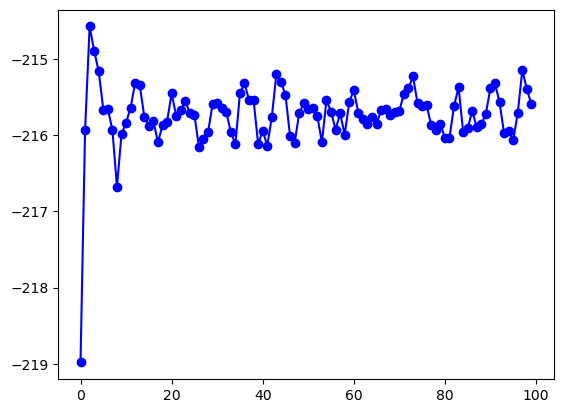

{'plot__axis': None}

In [19]:
wf = Workflow('lammps_macro')
wf.bulk = pn.atomistic.structure.build.CubicBulkCell('Pb', cell_size=3)
wf.inp_calc_md = pn.atomistic.calculator.data.InputCalcMD()
wf.lammps = pn.atomistic.engine.lammps.Code(structure=wf.bulk, calculator=wf.inp_calc_md) 
wf.energies = pn.atomistic.engine.lammps.GetEnergyPot(generic=wf.lammps)
wf.plot = pn.plotting.Plot(y=wf.energies)

# wf.bulk.pull()
# wf.lammps.Collect.pull() # works
wf.run()

In [20]:
pf = PyironFlow([wf])
pf.gui

In [1]:
# json.loads(pf.wf_widgets[0].gui.nodes)[1];

from python.reactflow import get_node_types, _get_type_name, _get_generic_type
import typing

def get_node_types(node_io):
    node_io_types = list()
    for k in node_io.channel_dict:
        type_hint = node_io[k].type_hint
        # print (k, type(type_hint))
        if isinstance(type_hint, typing._UnionGenericAlias):
            # print (k, type_hint)
            type_hint = _get_generic_type(type_hint)

        node_io_types.append(_get_type_name(type_hint))
    return node_io_types

# wf.inp_calc_md.inputs.channel_dict['temperature'].type_hint

In [22]:
get_node_types(wf.bulk.inputs), get_node_types(wf.inp_calc_md.inputs);

In [23]:
wf.bulk.inputs.channel_dict['vacancy_index'].type_hint

typing.Optional[int]

In [ ]:
def f(a:int=3):
    return a

In [ ]:
f.__annotations__

In [ ]:
def f(a, b, c: int=3):
    return a

In [ ]:
from inspect import signature

In [ ]:
f'f{str(signature(f))}'

In [ ]:
a = pn.atomistic.structure.build.CubicBulkCell

In [ ]:
signature(a)

In [ ]:
pf = PyironFlow([])
pf.gui

In [ ]:
wf = pf.get_workflow()
wf

In [ ]:
pf = PyironFlow([wf])
pf.gui

In [2]:
from python.reactflow import get_node_types, _get_type_name, _get_generic_type
import typing

def get_node_types(node_io):
    node_io_types = list()
    for k in node_io.channel_dict:
        type_hint = node_io[k].type_hint
        # print (k, type(type_hint))
        if isinstance(type_hint, typing._UnionGenericAlias):
            # print (k, type_hint)
            type_hint = _get_generic_type(type_hint)

        node_io_types.append(_get_type_name(type_hint))
    return node_io_types

In [12]:
from pyiron_workflow import as_dataclass_node
from typing import Optional

# @as_dataclass_node
class InputCalcMD:
    temperature: Optional[int | float] = 300
    n_ionic_steps: int = 10_000
    n_print: int = 100
    pressure: Optional[int | float] = None
    time_step: Optional[int | float] = 1.0
    temperature_damping_timescale: Optional[int | float] = 100.0
    pressure_damping_timescale: Optional[int | float] = 1000.0
    seed: Optional[int] = None
    tloop: Optional[float] = None
    initial_temperature: Optional[float] = None
    langevin: bool = False
    delta_temp: Optional[float] = None
    delta_press: Optional[float] = None

InputCalcMD??

Init signature: InputCalcMD()
Docstring:      <no docstring>
Type:           type
Subclasses:     

In [4]:
ic_md = InputCalcMD()
get_node_types(ic_md.inputs)

['float',
 'int',
 'int',
 'float',
 'float',
 'float',
 'float',
 'int',
 'float',
 'float',
 'bool',
 'float',
 'float']

In [13]:
from pyiron_nodes.atomistic.calculator.data import InputCalcMD

ic_md = as_dataclass_node(InputCalcMD)()
get_node_types(ic_md.inputs)

['NonPrimitive',
 'NonPrimitive',
 'NonPrimitive',
 'NonPrimitive',
 'NonPrimitive',
 'NonPrimitive',
 'NonPrimitive',
 'NonPrimitive',
 'NonPrimitive',
 'NonPrimitive',
 'NonPrimitive',
 'NonPrimitive',
 'NonPrimitive']

In [14]:
InputCalcMD??

Init signature:
InputCalcMD(
    temperature: 'Optional[int | float]' = 300,
    n_ionic_steps: 'int' = 10000,
    n_print: 'int' = 100,
    pressure: 'Optional[int | float]' = None,
    time_step: 'Optional[int | float]' = 1.0,
    temperature_damping_timescale: 'Optional[int | float]' = 100.0,
    pressure_damping_timescale: 'Optional[int | float]' = 1000.0,
    seed: 'Optional[int]' = None,
    tloop: 'Optional[float]' = None,
    initial_temperature: 'Optional[float]' = None,
    langevin: 'bool' = False,
    delta_temp: 'Optional[float]' = None,
    delta_press: 'Optional[float]' = None,
) -> None
Docstring:      InputCalcMD(temperature: 'Optional[int | float]' = 300, n_ionic_steps: 'int' = 10000, n_print: 'int' = 100, pressure: 'Optional[int | float]' = None, time_step: 'Optional[int | float]' = 1.0, temperature_damping_timescale: 'Optional[int | float]' = 100.0, pressure_damping_timescale: 'Optional[int | float]' = 1000.0, seed: 'Optional[int]' = None, tloop: 'Optional[float]' =

In [ ]:
pn.atomistic.engine.lammps.SetInputCalcMD().color

In [ ]:
type(pn.atomistic.calculator.data.InputCalcMD().run())

In [ ]:
isinstance(pn.atomistic.calculator.data.InputCalcMD().run(), pyiron_nodes.atomistic.calculator.data.InputCalcMD.dataclass)